# Install dependencies

In [0]:
!pip install torch
!pip install fastai

# Imports

In [0]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from sklearn.model_selection import train_test_split

# Connect Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
dataset_path = "gdrive/My Drive/datasets/torrent_meta_dataset.csv"
data = pd.read_csv(dataset_path, names=['label','meta'], header=None)
df = pd.DataFrame({'label':data['label'], 'meta':data['meta']})

train_set, valid_set = train_test_split(df, stratify = df['label'], test_size = 0.3, random_state = 12)
train_set.shape, valid_set.shape

((1675, 2), (718, 2))

# Create Language model dataset



In [0]:
lang_dataset = TextLMDataBunch.from_df(train_df = train_set, valid_df = valid_set, path='')

# Create Classifier model dataset

In [0]:
clas_dataset = TextClasDataBunch.from_df(path = "", train_df = train_set, valid_df = valid_set, vocab=lang_dataset.train_ds.vocab, bs=32)

# Creating Language learner

In [0]:
lang_learn = language_model_learner(lang_dataset, arch = AWD_LSTM, pretrained = True, drop_mult=0.7)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 9.12E-02


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


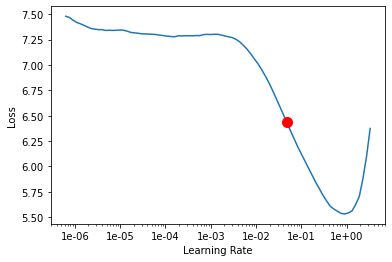

In [0]:
lang_learn.lr_find()
lang_learn.recorder.plot(suggestion=True)
min_grad_lr = lang_learn.recorder.min_grad_lr

In [0]:
lang_learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,2.758621,2.334458,0.572933,00:33
1,1.894550,2.068602,0.609487,00:34


In [0]:
lang_learn.predict("S01E03", n_words=10)

'S01E03 700 MB webrip 800 MB x264galaxyrg mkv length'

In [0]:
lang_learn.save_encoder('encoder')

# Create Classifiyer learner

In [0]:
clas_learn = text_classifier_learner(clas_dataset, AWD_LSTM, drop_mult=0.7)
clas_learn.load_encoder('encoder')
# clas_learn.load('class_learn')

Plot and fit several times according to figures

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 5.75E-03


epoch,train_loss,valid_loss,accuracy,time
0,0.707230,0.621301,0.619777,00:48
1,0.699120,0.611176,0.655989,00:46
2,0.668305,0.543587,0.781337,00:51


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 1.00E-02


epoch,train_loss,valid_loss,accuracy,time
0,0.667237,0.574848,0.707521,00:45
1,0.627837,0.544850,0.774373,00:50
2,0.627102,0.556590,0.736769,00:49


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 1.20E-04


epoch,train_loss,valid_loss,accuracy,time
0,0.640034,0.538032,0.781337,00:51
1,0.638861,0.551529,0.767409,00:46
2,0.630064,0.549505,0.753482,00:56


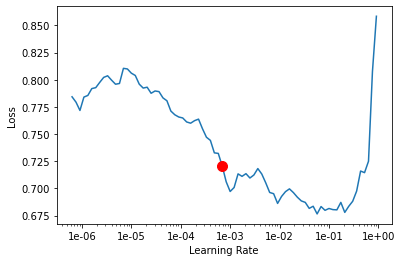

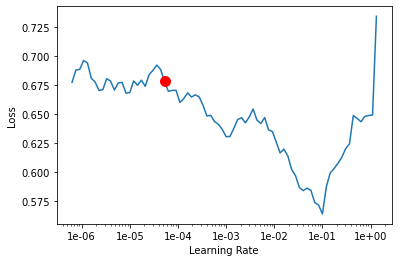

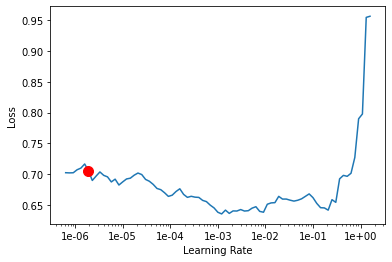

In [0]:
for _ in range(3):
  clas_learn.lr_find()
  clas_learn.recorder.plot(suggestion=True)
  min_grad_lr = clas_learn.recorder.min_grad_lr
  clas_learn.fit_one_cycle(3, slice(min_grad_lr, min_grad_lr/10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 3.02E-02


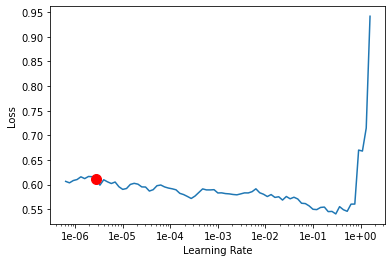

In [0]:
clas_learn.lr_find()
clas_learn.recorder.plot(suggestion=True)
min_grad_lr = clas_learn.recorder.min_grad_lr

In [0]:
clas_learn.fit_one_cycle(1, slice(min_grad_lr,min_grad_lr/10))

epoch,train_loss,valid_loss,accuracy,time
0,0.605434,0.498222,0.903900,00:43


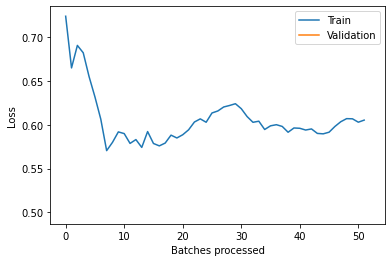

In [0]:
clas_learn.recorder.plot_losses()

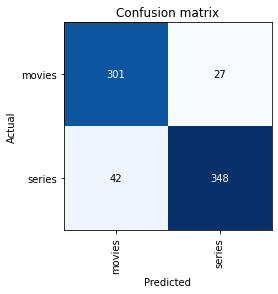

In [0]:
preds,y,losses = clas_learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(clas_learn, preds, y, losses)
interp.plot_confusion_matrix()

In [0]:
# clas_learn = load_learner("gdrive/My Drive/Colab Notebooks/")
clas_learn.save('clas_learn')
clas_learn.export()

In [34]:
# Add actual torrent['info'] to predict
import string
info = "created by14:uTorrent/3.5.513:creation datei1584241859e8:encoding5:UTF-84:infod13:file-durationli0ei0ei6474ee10:file-mediali-1ei-1ei0ee5:filesld6:lengthi100361e4:pathl51:Vozhdelenie.2007.DUAL.BDRip.XviD.AC3.-HRIME.ENG.srteed6:lengthi133583e4:pathl51:Vozhdelenie.2007.DUAL.BDRip.XviD.AC3.-HRIME.RUS.srteed6:lengthi3117326336e4:pathl47:Vozhdelenie.2007.DUAL.BDRip.XviD.AC3.-HRIME.avieee4:name43:Vozhdelenie.2007.DUAL.BDRip.XviD.AC3.-HRIME12:piece lengthi4194304e6"
clean_info = info.replace('.', ' ').translate(str.maketrans('', '', string.punctuation))
prediction = clas_learn.predict(clean_info)
confidence = float(max(prediction[2][0],prediction[2][1]))
if confidence > .55:
  print(str(prediction[0])+" "+str(round(confidence,2)))
else:
  print("uncertain")

movies 0.95
